#Clustering Analysis for Customer Segmentation

##Upload Dataset

In [1]:
from google.colab import files
uploaded = files.upload()


Saving Online Retail.xlsx to Online Retail.xlsx


##Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


##Load and Inspect the Dataset

In [7]:
# Load the dataset
data = pd.read_excel('Online Retail.xlsx')

# Check the first few rows of the dataset
data.head()

# Check data types and missing values
data.info()

# Descriptive statistics for numerical columns
data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


##Data Preprocessing

###Handle Missing Values

In [8]:
# Drop rows with missing values (if applicable)
data.dropna(inplace=True)

# Or, fill missing values (example: fill with column mean)
# data['UnitPrice'].fillna(data['UnitPrice'].mean(), inplace=True)


###Create Customer-Level Aggregates

In [9]:
# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Create 'TotalSpent' column
data['TotalSpent'] = data['Quantity'] * data['UnitPrice']

# Aggregate data by CustomerID
customer_data = data.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',            # Frequency of purchases
    'Quantity': 'sum',                 # Total quantity purchased
    'TotalSpent': 'sum',               # Total money spent
    'InvoiceDate': 'max'               # Most recent purchase date
}).reset_index()

# Rename columns for clarity
customer_data.rename(columns={
    'InvoiceNo': 'Frequency',
    'Quantity': 'TotalQuantity',
    'TotalSpent': 'TotalSpending',
    'InvoiceDate': 'LastPurchase'
}, inplace=True)

# Recency: Calculate the days since last purchase
current_date = data['InvoiceDate'].max()
customer_data['Recency'] = (current_date - customer_data['LastPurchase']).dt.days

# Drop 'LastPurchase' column as it's no longer needed
customer_data.drop(columns='LastPurchase', inplace=True)

# View the processed customer-level data
customer_data.head()


,CustomerID,Frequency,TotalQuantity,TotalSpending,Recency
0,12346.0,2,0,0.00,325
1,12347.0,7,2458,4310.00,1
2,12348.0,4,2341,1797.24,74
3,12349.0,1,631,1757.55,18
4,12350.0,1,197,334.40,309


##Data Scaling

In [10]:
# Features to scale
features_to_scale = ['Frequency', 'TotalQuantity', 'TotalSpending', 'Recency']

# Initialize the scaler
scaler = StandardScaler()

# Scale the data
scaled_features = scaler.fit_transform(customer_data[features_to_scale])

# Convert scaled features back into a DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=features_to_scale)

# Add CustomerID back to the scaled data
scaled_data['CustomerID'] = customer_data['CustomerID']

# View the scaled data
scaled_data.head()


,Frequency,TotalQuantity,TotalSpending,Recency,CustomerID
0,-0.329362,-0.240215,-0.231001,2.322023,12346.0
1,0.206102,0.285870,0.293432,-0.893733,12347.0
2,-0.115176,0.260828,-0.012316,-0.169196,12348.0
3,-0.436455,-0.105162,-0.017146,-0.725005,12349.0
4,-0.436455,-0.198051,-0.190312,2.163220,12350.0


##Apply K-Means Clustering

In [11]:
# Initialize KMeans with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)

# Fit the model and predict the clusters
scaled_data['Cluster'] = kmeans.fit_predict(scaled_data[features_to_scale])

# View the clustered data
scaled_data.head()


,Frequency,TotalQuantity,TotalSpending,Recency,CustomerID,Cluster
0,-0.329362,-0.240215,-0.231001,2.322023,12346.0,3
1,0.206102,0.285870,0.293432,-0.893733,12347.0,0
2,-0.115176,0.260828,-0.012316,-0.169196,12348.0,0
3,-0.436455,-0.105162,-0.017146,-0.725005,12349.0,0
4,-0.436455,-0.198051,-0.190312,2.163220,12350.0,3


##Evaluate the Clustering

In [12]:
# Calculate Silhouette Score
score = silhouette_score(scaled_data[features_to_scale], scaled_data['Cluster'])
print(f'Silhouette Score: {score}')


Silhouette Score: 0.5975022525386933


##Visualize the Clusters

### 2D Scatter Plot

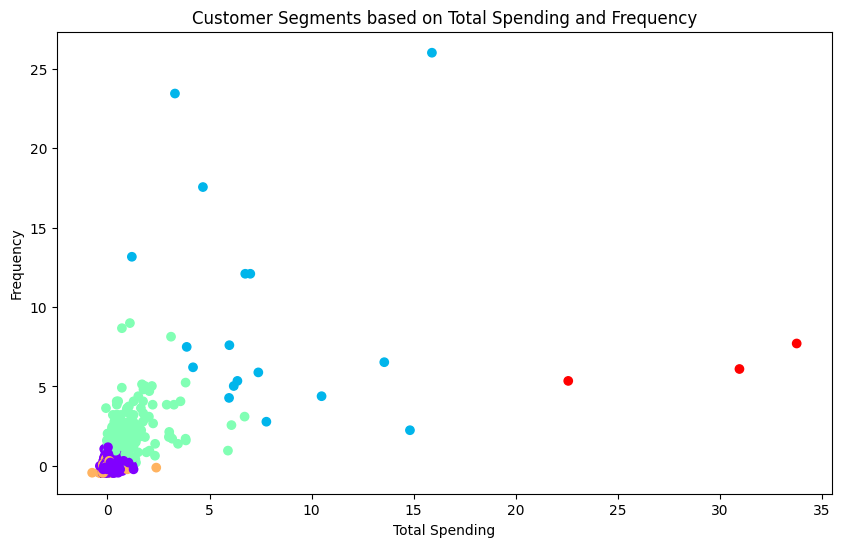

In [13]:
plt.figure(figsize=(10,6))
plt.scatter(scaled_data['TotalSpending'], scaled_data['Frequency'], c=scaled_data['Cluster'], cmap='rainbow')
plt.title('Customer Segments based on Total Spending and Frequency')
plt.xlabel('Total Spending')
plt.ylabel('Frequency')
plt.show()


###Pair Plot

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

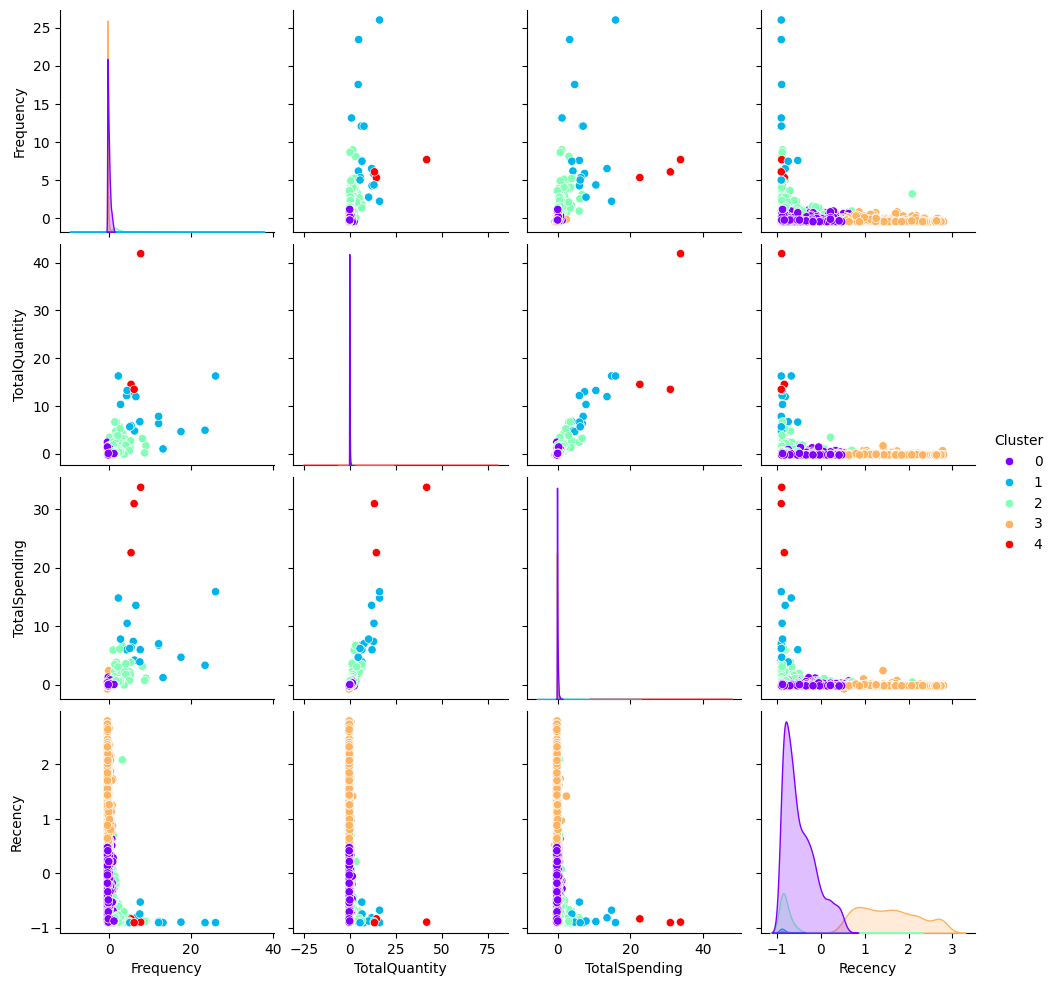

In [14]:
sns.pairplot(data=scaled_data, vars=features_to_scale, hue='Cluster', palette='rainbow')
plt.show()


##Interpret the Clusters

###Examine Cluster Characteristics

In [15]:
# Group data by Cluster to observe cluster characteristics
cluster_summary = scaled_data.groupby('Cluster').mean()
cluster_summary


,Frequency,TotalQuantity,TotalSpending,Recency,CustomerID
Cluster,,,,,
0,-0.105150,-0.081935,-0.083271,-0.482109,15294.037185
1,9.535785,8.694227,7.379438,-0.844107,15089.588235
2,1.925225,0.859502,0.853518,-0.775228,15148.454887
3,-0.350701,-0.185775,-0.175983,1.559873,15352.272812
4,6.381794,23.293740,29.110040,-0.877191,16732.666667


###Cluster Interpretations:

**Cluster 0**:
 This cluster has low values across all metrics (Frequency, Total Quantity, Total Spending) and a high Recency score. These customers appear to be infrequent buyers with small purchase amounts, indicating they may need targeted marketing efforts to re-engage them.


**Cluster 1**: This group exhibits extremely high Frequency, Total Quantity, and Total Spending scores, indicating that these are high-value, frequent customers. They should be prioritized for loyalty programs and exclusive offers to maintain their engagement and maximize their lifetime value.

**Cluster 2**: Customers in this cluster have moderate scores for Frequency and Total Spending, with a relatively low Recency score. These customers are likely to be occasional buyers who still exhibit a good level of engagement. Targeting them with promotions could encourage more frequent purchases.

**Cluster 3**: This cluster shows low Frequency and Total Quantity scores with a higher Recency score, suggesting these customers have become less active. They may require re-engagement strategies to stimulate further purchasing behavior.


 **Cluster 4**: This group has a high Total Quantity and Total Spending score, indicating they are significant contributors to revenue. They exhibit moderate Frequency and a low Recency score, suggesting they are still actively engaged. Personalized marketing efforts could further enhance their buying experience and loyalty.

##Conclusion and Business Insights

###Conclusion:

1. **Data Cleaning and Preprocessing**: The dataset was cleaned by addressing missing values and creating customer-level metrics such as Total Spending, Frequency, and Recency.
2. **Feature Engineering**: Key metrics were derived to capture customer behavior effectively, enabling meaningful segmentation.
3. **Clustering**: K-Means clustering was applied to identify distinct customer segments, leading to the formation of 5 unique clusters based on purchasing behavior.
4. **Visualization**: The clusters were visualized to aid in understanding customer segments visually, making it easier to interpret their characteristics.

###Business Insights:

- **Cluster 0**: Target this group with re-engagement strategies and promotions to stimulate purchases, as they currently show low activity.
- **Cluster 1**: Focus on retaining these high-value customers by offering exclusive deals and loyalty rewards to encourage their continued patronage.
- **Cluster 2**: Develop targeted marketing campaigns to convert these occasional buyers into more frequent purchasers, possibly through time-sensitive promotions.
- **Cluster 3**: Implement strategies aimed at re-engaging these customers, as they exhibit decreased purchasing activity but have potential for return.
- **Cluster 4**: Enhance the shopping experience for these high-engagement customers through personalized offers and targeted communication to further boost their spending and loyalty.